In [3]:
!pip install pandas
!pip install qiskit==0.39.2
!pip install numpy
!pip install seaborn
!pip install matplotlib
!pip install scipy


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 75.5 MB/s eta 0:00:0000:010:01

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python3.9 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 45.9 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python3.9 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python3.9 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 84.8 MB/s eta 0:00:000

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
import shin_metiu_full as sf
import matplotlib as mpl

# import ipywidgets as widgets
import pandas as pd
import seaborn as sns

from ansatze import hweff_ansatz
from qiskit import Aer
from exact_simulator import prep_ham, simulation, inner

from auto_plotter import autoplotter, prep_dfs
import warnings

mpl.rcParams['text.usetex'] = True

warnings.filterwarnings("ignore")
sns.set_context(
    "talk",
    rc={
        "text.usetex": True,
        "font.size": 18,
        "axes.titlesize": 18,
        "axes.labelsize": 18,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "legend.fontsize": 16,
        "legend.loc": "lower left",
        "legend.frameon": False,
        "font.family": "serif",
        "font.serif": "Times New Roman",
    },
)

from helpers import read_files

df,df_coef=read_files(100,700,'results_incomplete/LONG/long_vqd',ending='json')

/home/danielb/miniconda3/envs/qiskit/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
numfiles = 100
max_times =700
results = []
dfs = []
fin_files = 0
for i in range(0, numfiles):
    try:
        file = f"results_incomplete/LONG/long_vqd{i}.json"
        #file = f"results/unknown/trycorrect{i}.json"
        data = json.load(open(file))
        results.append(data)
        for j in ['QC','ideal','exact']:
            datadf = pd.DataFrame(data[f'{j}_coefficients'])
            datadf=datadf.reset_index()
            datadf = datadf.melt(id_vars='index',var_name='Adiabatic state',value_name='Population')
            datadf['Setup:'] = f'{j}'
            datadf['sample'] = i
            datadf['Time'] = datadf['index']*data['dt']
            dfs.append(datadf)
        fin_files+=1
    except:
        pass
numfiles=fin_files
datadf = pd.concat(dfs,ignore_index=True)
stuff = [
    "fidelity_to_ideal",
    "fidelity_to_exact",
    "ideal_forces_el",
    "ideal_forces_nuc",
    "ideal_tot_forces",
    "ideal_velocities",
    "ideal_positions",
    "ideal_energy_el",
    "ideal_energy_Tnuc",
    "ideal_energy_Vnuc",
    "exact_forces_el",
    "exact_forces_nuc",
    "exact_tot_forces",
    "exact_velocities",
    "exact_positions",
    "exact_energy_el",
    "exact_energy_Tnuc",
    "exact_energy_Vnuc",
    "QC_forces_el",
    "QC_forces_nuc",
    "QC_tot_forces",
    "QC_velocities",
    "QC_positions",
    "QC_energy_el",
    "QC_energy_Tnuc",
    "QC_energy_Vnuc",
    "force",
    "err_force",
    "energy",
    "err_energy",
    "init_F",
    "final_F",
    "err_init_F",
    "err_fin_F",
    "iter_number",
    "times",
]

store = {i: [] for i in stuff}
store["sample"] = []

for i in range(numfiles):
    for j in stuff:
        store[j].extend(results[i][j][0:max_times])
        # print(len(store[j]))
    store["sample"].extend([i] * max_times)
# print(len(store["sample"]))

df = pd.DataFrame(store)
df["diff_ideal_exact"] = np.abs(df["fidelity_to_exact"] - df["fidelity_to_ideal"])
df['ideal_energy'] = df['ideal_energy_el']+df['ideal_energy_Vnuc']+df['ideal_energy_Tnuc']
df['QC_energy'] = df['QC_energy_el']+df['QC_energy_Vnuc']+df['QC_energy_Tnuc']-df['ideal_energy']
df['exact_energy'] = df['exact_energy_el']+df['exact_energy_Vnuc']+df['exact_energy_Tnuc']-df['ideal_energy']
df['ideal_energy'] = df['ideal_energy']-df['ideal_energy'][0]
coeff_names  ={'exact_coefficients':'Exact',
'ideal_coefficients':'Ideal',
'QC_coefficients': 'TDVQP'}

store_coef = {coeff_names[i]: [] for i in coeff_names}
store_coef['Time'] = []
store_coef['State'] = []
store_coef["Sample"] = []
for i in range(numfiles):
    for j in coeff_names:
        for k, res in enumerate(results[i][j][0:max_times]):        
            store_coef[coeff_names[j]].extend(res[0:15]) # only really need highest 5 populations even in larger simulations with superpositions.
            if j == 'exact_coefficients':
                store_coef['Time'].extend([results[i]['times'][k]]*15)
                store_coef["Sample"].extend([i] * 15)
                store_coef['State'].extend(list(range(15)))
                
df_coef = pd.DataFrame(store_coef).melt(id_vars=('Time','State','Sample'),value_name='Population',var_name='Type')
del results
del store
del store_coef
del dfs

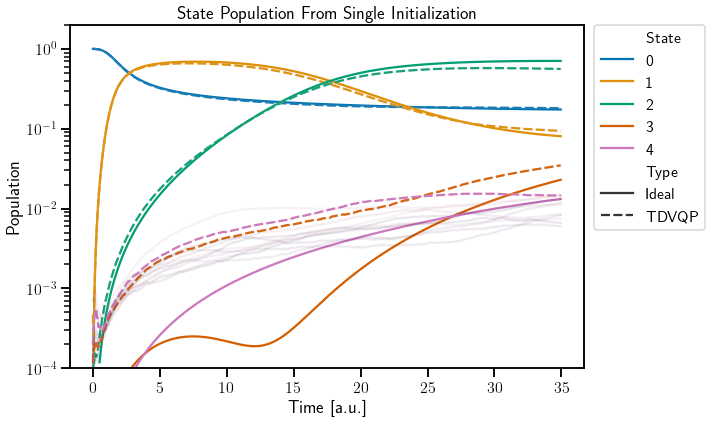

In [2]:
fig, ax = plt.subplots(figsize=((10, 6)))
sns.lineplot(data=df_coef.query('State<5 & Population>1e-4 &Type!="Exact"'),x='Time',y='Population',hue='State',style='Type',ci=None,ax=ax,palette=sns.color_palette("colorblind"))
sns.lineplot(data=df_coef.query('State<15 & Population>1e-4 &Type=="TDVQP"'),x='Time',y='Population',hue='State',style='Type',ci=None,ax=ax,legend=None,alpha=0.1)
plt.xlabel(r'Time [a.u.]')
# plt.ylabel(r'Population')
plt.ylim([1e-4,2])
plt.yscale('log')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title(r'State Population From Single Initialization')
plt.tight_layout()
plt.savefig('./custom_plots/single_populations_long.pdf')

In [17]:
dash_list = sns._core.unique_dashes(df['sample'].unique().size+1)
style = {key:value for key,value in zip(df['sample'].unique(), dash_list[1:])}


AttributeError: module 'seaborn._core' has no attribute 'unique_dashes'

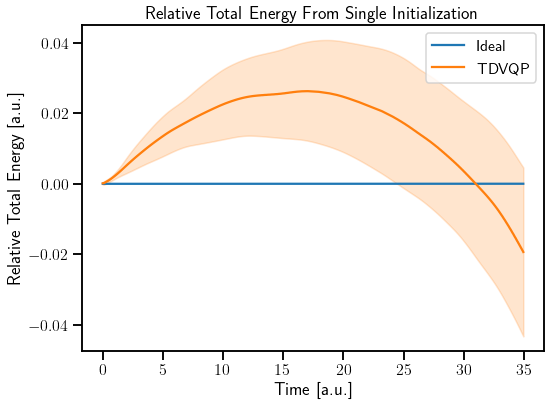

In [11]:
fig, ax = plt.subplots(figsize=((8, 6)))
sns.lineplot(data=df, x="times", y="ideal_energy", ci=None, ax=ax,label='Ideal')
sns.lineplot(data=df, x="times", y="QC_energy", ci='sd', ax=ax, palette="Set2",label='TDVQP')
plt.ylabel(r'Relative Total Energy [a.u.]')
plt.xlabel(r'Time [a.u.]')
plt.title(r'Relative Total Energy From Single Initialization')
plt.tight_layout()
plt.savefig("custom_plots/Single_energy_long.pdf")

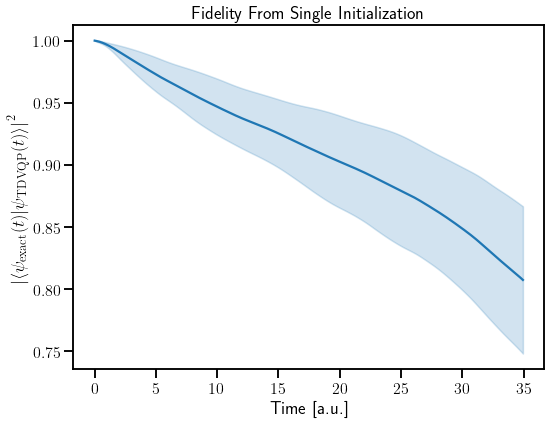

In [12]:
fig, ax = plt.subplots(figsize=((8, 6)))
sns.lineplot(data=df, x="times", y="fidelity_to_exact", ci="sd", ax=ax)#, label = 'compared to exact evoltuion of VQE state')
# sns.lineplot(data=df, x="times", y="fidelity_to_ideal", ci="sd", ax=ax, label= 'compared to ideal state evolution')
# plt.ylabel('Fidelity')
ax.set(ylabel=r'$\left |\langle\psi_\mathrm{exact}(t)|\psi_\mathrm{TDVQP}(t)\rangle\right |^2 $',xlabel= r'Time [a.u.]')
plt.tight_layout()
plt.title('Fidelity From Single Initialization')
plt.savefig("custom_plots/Single_fidelity_long.pdf")

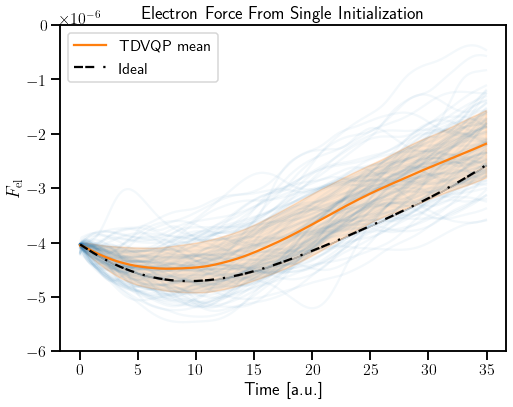

In [13]:
fig, ax = plt.subplots(figsize=((8, 6)))
sns.lineplot(data=df, x="times", y="QC_forces_el", ax=ax, units="sample", estimator=None, alpha=0.05,label=None)
plt.legend('')
# sns.lineplot(
#     data=df, x="times", y="QC_forces_el", ci=None, estimator=lambda x: np.percentile(x, 25), ax=ax, alpha=1, style='err_energy', dashes=[(4,2,4)], color = 'r', label='TDVQP lower quartile'
# )
# # sns.lineplot(
# #     data=df, x="times", y="QC_forces_el", ci=None, estimator=lambda x: np.percentile(x, 50), ax=ax, alpha=1, style='err_energy', dashes=[(4,1)], color = 'g', label='TDVQP median'
# # )
# sns.lineplot(
#     data=df, x="times", y="QC_forces_el", ci=None, estimator=lambda x: np.percentile(x, 75), ax=ax, alpha=1, style='err_energy', color = 'b', dashes=[(1,1)], label='TDVQP upper quartile')

sns.lineplot(
    data=df, x="times", y="QC_forces_el", ci="sd", estimator=np.mean, ax=ax, alpha=1, label = 'TDVQP mean'
)

sns.lineplot(data=df, x="times", y="ideal_forces_el", ci="sd", ax=ax,color='black', label='Ideal',style='err_energy', dashes=[(4,1,4)])
# sns.lineplot(data=df, x="times", y="exact_forces_el", ci="sd", ax=ax,color='purple',label='Exact from VQE initial state')
ax.set_ylim([-6e-6,0])

handles, labels = ax.get_legend_handles_labels()
l = plt.legend([handles[i] for i in [0,1]], [labels[i] for i in [0,1]])
ax.set(ylabel='$F_\mathrm{el}$',xlabel= r'Time [a.u.]',title='Electron Force From Single Initialization')
plt.savefig("custom_plots/S_force_long.pdf")

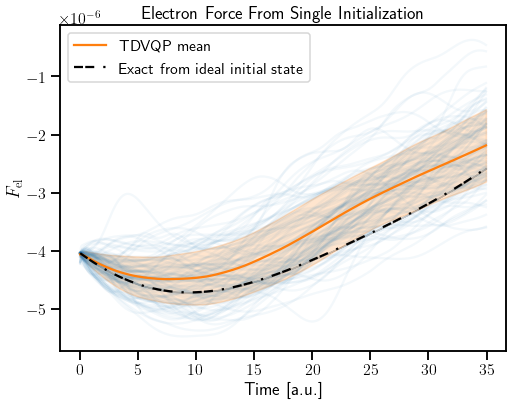

In [14]:

fig, ax = plt.subplots(figsize=((8, 6)))
sns.lineplot(data=df, x="times", y="QC_forces_el", ax=ax, units="sample", estimator=None, alpha=0.05,label=None)
plt.legend('')
# sns.lineplot(
#     data=df, x="times", y="QC_forces_el", ci=None, estimator=lambda x: np.percentile(x, 25), ax=ax, alpha=1, style='err_energy', dashes=[(4,1,4)], color = 'r', label='TDVQP lower quartile'
# )
# # sns.lineplot(
# #     data=df, x="times", y="QC_forces_el", ci=None, estimator=lambda x: np.percentile(x, 50), ax=ax, alpha=1, style='err_energy', dashes=[(4,1)], color = 'g', label='QC median'
# # )
# sns.lineplot(
#     data=df, x="times", y="QC_forces_el", ci=None, estimator=lambda x: np.percentile(x, 75), ax=ax, alpha=1, style='err_energy', color = 'b', dashes=[(1,1)], label='TDVQP upper quartile')

sns.lineplot(
    data=df, x="times", y="QC_forces_el", errorbar=("sd",1), estimator=np.mean, ax=ax, alpha=1, label = 'TDVQP mean'
)

sns.lineplot(data=df, x="times", y="ideal_forces_el", errorbar="sd", ax=ax,color='black', label='Exact from ideal initial state',style='err_energy', dashes=[(4,1,4)])
# sns.lineplot(data=df, x="times", y="exact_forces_el", ci="sd", ax=ax,color='purple',label='Exact from VQE initial state')
handles, labels = ax.get_legend_handles_labels()

l = plt.legend([handles[i] for i in [0,1]], [labels[i] for i in [0,1]])
ax.set(ylabel='$F_\mathrm{el}$',xlabel= r'Time [a.u.]',title='Electron Force From Single Initialization')
plt.savefig("custom_plots/S_force_long.pdf")

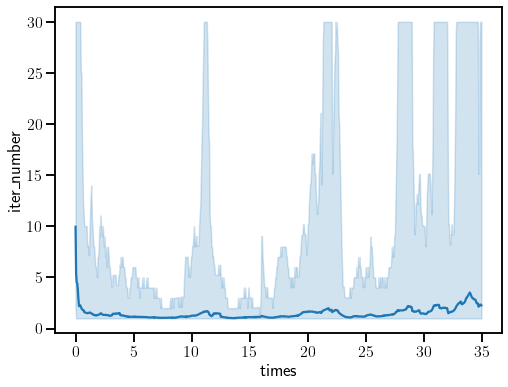

In [18]:
fig, ax = plt.subplots(figsize=((8, 6)))
sns.lineplot(data=df, y="iter_number", x="times", ax=ax, errorbar=(lambda x: (np.percentile(x, 25), np.percentile(x, 99))))
# sns.lineplot(data=df, x="times", y="iter_number", ax=ax, hue="sample", alpha=0.05)

# sns.lineplot(
#     data=df, x="times", y="QC_energy_Tnuc", ci=None, estimator=lambda x: np.percentile(x, 25), ax=ax, alpha=1, style='err_energy', dashes=[(4,1,4)], color = 'r', label='QC lower quartile'
# )
# sns.lineplot(
#     data=df, x="times", y="QC_energy_Tnuc", ci=None, estimator=lambda x: np.percentile(x, 50), ax=ax, alpha=1, style='err_energy', dashes=[(4,1)], color = 'g', label='QC median'
# )

# sns.lineplot(
#     data=df, x="times", y="QC_energy_Tnuc", ci=None, estimator=lambda x: np.percentile(x, 75), ax=ax, alpha=1, style='err_energy', color = 'b', dashes=[(1,1)], label='QC upper quartile')

# sns.lineplot(
#     data=df, x="times", y="QC_energy_Tnuc", ci="sd", estimator=np.mean, ax=ax, alpha=1, label = 'QC mean'
# )

# sns.lineplot(data=df, x="times", y="ideal_energy_Tnuc", ci="sd", ax=ax,color='black', label = 'Ideal')
# sns.lineplot(data=df, x="times", y="exact_forces_el", ci="sd", ax=ax,color='purple')

plt.show()

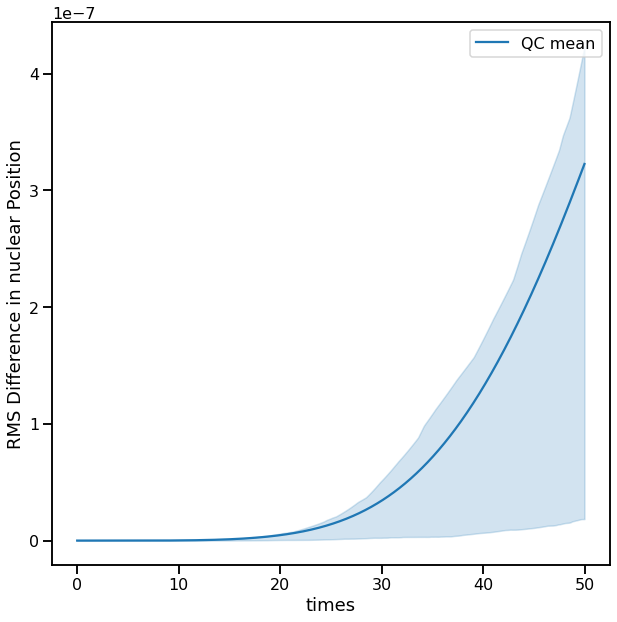

In [14]:
fig, ax = plt.subplots(figsize=((10, 10)))

df['diff_pos'] = (df['QC_positions']-df["ideal_positions"])**2
sns.lineplot(
    data=df, x="times", y="diff_pos", errorbar=(lambda x: (np.percentile(x, 25), np.percentile(x, 75))), estimator=np.mean, ax=ax, alpha=1, label = 'QC mean'
)

ax.set_ylabel('RMS Difference in nuclear Position')
plt.show()

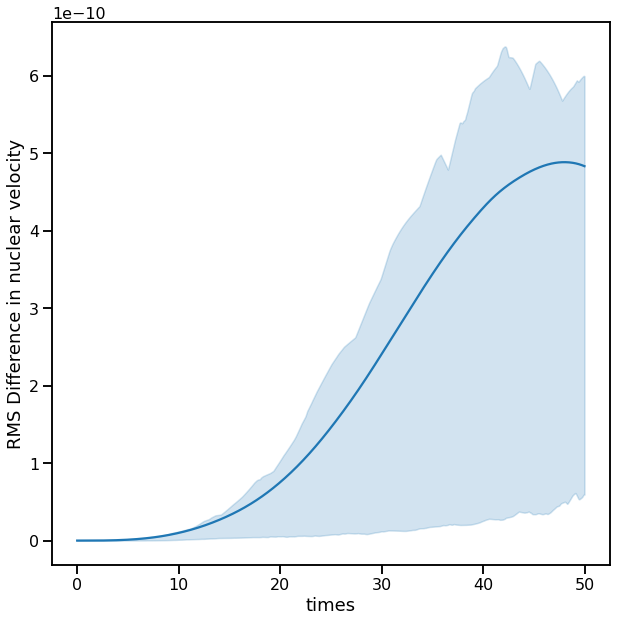

In [15]:
fig, ax = plt.subplots(figsize=((10, 10)))

df['diff_vel'] = (df['QC_velocities']-df["ideal_velocities"])**2
sns.lineplot(
    data=df, x="times", y="diff_vel", errorbar=(lambda x: (np.percentile(x, 25), np.percentile(x, 75))), estimator=np.mean, ax=ax, alpha=1, #label = 'QC mean'
)

ax.set_ylabel('RMS Difference in nuclear velocity')
plt.show()

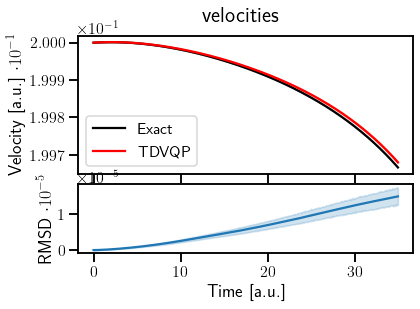

In [19]:
def plot(p,y,sc0,sc1):
    fig = plt.figure()
    gs = fig.add_gridspec(2, hspace=0.1, height_ratios=[2, 1])
    axs = gs.subplots(sharex=True)
    fig.suptitle(p)
    df[f'diff_{p}']=np.sqrt((df[f"exact_{p}"] - df[f"QC_{p}"])**2)
    sns.lineplot(ax=axs[1],data=df,x=f'times',y=f'diff_{p}',legend=None)
    sns.lineplot(ax=axs[0],
        data=df,y=f"exact_{p}",x='times',
        color="black",
        label="Exact",
    )
    sns.lineplot(ax=axs[0],
        data=df,y=f"QC_{p}",x='times',
        color="red",
        label="TDVQP",
    )
    axs[1].set_ylabel(f'RMSD ${sc1}$')
    axs[0].set_ylabel(f'{y} [a.u.] ${sc0}$')
    axs[0].set_xlabel('Time [a.u.]')
    axs[1].set_xlabel('Time [a.u.]')

    axs[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    axs[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    # axs[0].set_yscale('log')
    # axs[0].legend()
    # axs[1].legend(loc=4)
    # axs[0].set_yscale('log')
    # axs[1].set_yscale("log")
    plt.tight_layout()
    plt.show()
    
plot("velocities",'Velocity','\\cdot10^{-1}','\\cdot10^{-5}')

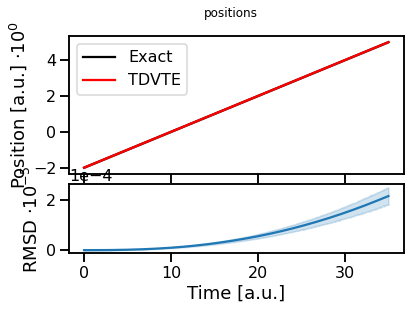

In [43]:
plot("positions",'Position','\\cdot10^{0}','\\cdot10^{-5}')

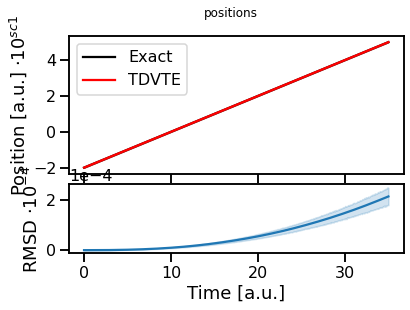

In [44]:
plot("positions",'Position','\\cdot10^{sc1}','\\cdot10^{-4}')